# **Trabajo Práctico: Predicción de Precios de Casas**

### **Tecnicatura Universitaria en Inteligencia Artificial**
### **Materia: Aprendizaje Automático 1**
### **Año:** 2024  
### **Integrantes:** Avecilla Tomás, Calcia Franco
### **Profesores: Agustín Almada, Bruno Cocitto, Joel Spak**

---

## **Introducción**

En este trabajo práctico, haremos una predicción de precios de viviendas utilizando técnicas de **regresión lineal múltiple**. Nuestro objetivo es hacer uso de las herramientas que proporciona la biblioteca **scikit-learn** para el pre-procesamiento de datos, la implementación de diferentes modelos de regresión y la evaluación de su desempeño mediante diversas métricas.

El dataset que utilizaremos contiene información detallada sobre viviendas en Boston, a través de un análisis exploratorio, estudiaremos la relación entre sus variables y el valor mediano de las viviendas para crear un modelo que sea capaz de predecir estos precios con precisión.

Además de construir el modelo, se probarán técnicas como la **regresión con gradiente descendente** y **métodos de regularización** (Lasso, Ridge, Elastic Net) para optimizar el ajuste y evitar el sobreajuste. Evaluaremos los resultados utilizando métricas como el **R2 Score**, el **Error Cuadrático Medio (MSE)** y otras, con el fin de seleccionar el mejor modelo.

Al final del trabajo, se realizará una **comparación de modelos** y se presentarán conclusiones sobre el desempeño del modelo final.


### Diccionario  de Datos

| Columna       | Descripción                                                                                          |
|---------------|---------------------------------------------------------------------------------------------------------------|
| **CRIM** | Tasa de criminalidad per cápita por ciudad.                       |
| **ZN**   | Proporción de terrenos residenciales zonificados para lotes de más de 25,000 pies cuadrados.                         |
| **INDUS**   | Proporción de acres de negocios no minoristas por ciudad.                         |
| **CHAS** | Variable dummy del río Charles (1 si el tramo limita con el río; 0 de lo contrario).                                                             |
| **NOX**   | Concentración de óxidos de nitrógeno (partes por 10 millones) [parts/10M].                                                          |
| **RM**        | Número promedio de habitaciones por vivienda.|
| **AGE**    | Proporción de unidades ocupadas por sus propietarios construidas antes de 1940.                                                        |
| **DIS**   | Distancias ponderadas a cinco centros de empleo de Boston.       |
| **RAD** | índice de accesibilidad a las autopistas radiales.                                                             |
| **TAX**   | Tasa de impuesto sobre la propiedad a valor completo por $10,000 [$/10k].                                                          |
| **PTRATIO**        | Proporción alumno-maestro por ciudad.|
| **B**    | El resultado de la ecuación B=1000(Bk - 0.63)^2 donde Bk es la proporción de negros por ciudad.                                                        |
| **LSTAT**   | % de población de menor estatus socioeconómico.       |
| **MEDV** *(Variable de salida)*  | Valor mediano de las viviendas ocupadas por sus propietarios en miles de dólares [k$].   | 


# Preparacion del entorno de Trabajo

In [343]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error
from matplotlib.colors import LinearSegmentedColormap
from sklearn.preprocessing import RobustScaler


In [344]:
df_precios_casas = pd.read_csv("house-prices-tp.csv")

# Train-Test
Decidimos hacer la division del dataset antes de comenzar el analisis y hacer cualquier tratado de datos ya que necesitamos que el dataset de testeo sea tomado como datos desconocidos

In [379]:
X_train, X_test, y_train, y_test = train_test_split(df_precios_casas.drop(columns=['MEDV']), df_precios_casas['MEDV'], test_size=0.2, random_state=42)

df_entrenamiento = pd.concat([X_train,y_train],axis=1)
df_test = pd.concat([X_test,y_test],axis=1)

# Análisis Exploratorio

## Limpieza de Datos

### Verificamos valores nulos

In [380]:
conteo_nan = df_entrenamiento.isnull().sum()
conteo_nan

CRIM       19
ZN         18
INDUS      12
CHAS       20
NOX        21
RM         17
AGE        22
DIS        14
RAD        26
TAX        13
PTRATIO    22
B          18
LSTAT      18
MEDV       19
dtype: int64

Como primera medida eliminaremos las fila que tengan la variable de salida nula o mas de 11 columnas nulas ya que las consideramos irrelevantes para el analisis

In [381]:
filas_nan = []

for index, row in df_entrenamiento.iterrows():
    # Verificamos si la fila tiene más de 11 NaN o si el valor de MEDV es NaN
    if row.isnull().sum() > 11 or pd.isnull(row['MEDV']):
        filas_nan.append(index)

df_entrenamiento.drop(index=filas_nan, inplace=True)

print(f"Filas eliminadas: {len(filas_nan)}")


Filas eliminadas: 19


In [382]:
conteo_nan = df_entrenamiento.isnull().sum()
conteo_nan

CRIM        7
ZN          8
INDUS       1
CHAS        7
NOX         7
RM          5
AGE         9
DIS         4
RAD        10
TAX         5
PTRATIO     5
B           6
LSTAT       6
MEDV        0
dtype: int64

Imputaremos la columna binaria con la moda

In [383]:
df_entrenamiento['CHAS'] = df_entrenamiento['CHAS'].fillna(df_entrenamiento['CHAS'].mode()[0])

Y el resto de columnas seran imputadas con KNN

In [384]:
imputer = KNNImputer(n_neighbors=5)

df_entrenamiento = pd.DataFrame(imputer.fit_transform(df_entrenamiento), columns=df_entrenamiento.columns)


In [385]:
conteo_nan = df_entrenamiento.isnull().sum()
conteo_nan

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

### Exploracion de outliers

Podemos notar varias variables con presencia de outliers por lo cual deberiamos hacer un analisis mas profundo

In [387]:
resultados_atipicos = {}

for columna in df_entrenamiento.columns:
    if df_entrenamiento[columna].dtype in ['int64', 'float64']:
        Q1 = df_entrenamiento[columna].quantile(0.25)
        Q3 = df_entrenamiento[columna].quantile(0.75)
        IQR = Q3 - Q1

        limite_inferior = Q1 - 1.5 * IQR
        limite_superior = Q3 + 1.5 * IQR

        es_atipico = (df_entrenamiento[columna] < limite_inferior) | (df_entrenamiento[columna] > limite_superior)

        cantidad_atipicos = es_atipico.sum()
        porcentaje_atipicos = (cantidad_atipicos / len(df_entrenamiento)) * 100

        resultados_atipicos[columna] = porcentaje_atipicos

for columna, porcentaje in resultados_atipicos.items():
    print(f"Columna: {columna} - Porcentaje de valores atípicos: {porcentaje:.2f}%")

Columna: CRIM - Porcentaje de valores atípicos: 13.18%
Columna: ZN - Porcentaje de valores atípicos: 11.76%
Columna: INDUS - Porcentaje de valores atípicos: 0.00%
Columna: CHAS - Porcentaje de valores atípicos: 7.53%
Columna: NOX - Porcentaje de valores atípicos: 0.00%
Columna: RM - Porcentaje de valores atípicos: 7.06%
Columna: AGE - Porcentaje de valores atípicos: 0.00%
Columna: DIS - Porcentaje de valores atípicos: 1.88%
Columna: RAD - Porcentaje de valores atípicos: 0.00%
Columna: TAX - Porcentaje de valores atípicos: 0.00%
Columna: PTRATIO - Porcentaje de valores atípicos: 0.00%
Columna: B - Porcentaje de valores atípicos: 18.35%
Columna: LSTAT - Porcentaje de valores atípicos: 2.12%
Columna: MEDV - Porcentaje de valores atípicos: 6.82%


Aunque se detectaron valores atípicos en algunas columnas, el porcentaje en la mayoría es bajo. Decidimos no aplicar técnicas de tratamiento para evitar perder información relevante, ya que los outliers pueden reflejar variaciones reales en los datos.

## Analisis Descriptivo

In [389]:
df_entrenamiento.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000
mean,5.529209,13.888083,11.015116,0.075294,0.557949,6.268923,66.761486,3.956498,9.536218,410.502761,18.386908,347.243733,12.884819,22.929072
std,12.686008,25.441893,6.832557,0.264176,0.119567,0.742067,28.693630,2.229679,8.551540,165.365812,2.216476,99.270150,7.504014,9.406067
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.079780,0.000000,4.987915,0.000000,0.449000,5.880000,41.839732,2.124700,4.000000,281.000000,16.900000,370.220000,7.033962,17.100000
50%,0.269380,0.000000,8.937346,0.000000,0.538000,6.209000,74.400000,3.363300,5.000000,348.000000,19.000000,390.550000,11.380000,21.600000
75%,4.835670,20.000000,18.100000,0.000000,0.633879,6.649000,93.000000,5.400700,17.164570,652.148598,20.200000,395.990000,17.100000,26.600000
max,79.412097,100.000000,27.740000,1.000000,0.871000,8.704000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,36.980000,50.000000


In [390]:
df_entrenamiento.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425 entries, 0 to 424
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     425 non-null    float64
 1   ZN       425 non-null    float64
 2   INDUS    425 non-null    float64
 3   CHAS     425 non-null    float64
 4   NOX      425 non-null    float64
 5   RM       425 non-null    float64
 6   AGE      425 non-null    float64
 7   DIS      425 non-null    float64
 8   RAD      425 non-null    float64
 9   TAX      425 non-null    float64
 10  PTRATIO  425 non-null    float64
 11  B        425 non-null    float64
 12  LSTAT    425 non-null    float64
 13  MEDV     425 non-null    float64
dtypes: float64(14)
memory usage: 46.6 KB


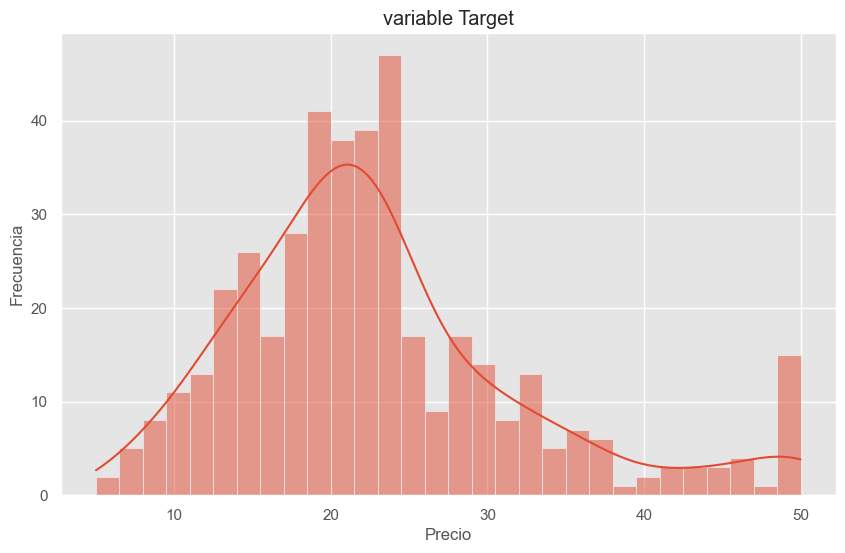

In [391]:
plt.figure(figsize=(10, 6))
sns.histplot(df_entrenamiento['MEDV'], bins=30, kde=True)
plt.title('variable Target')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
plt.show()

La variable objetivo (MEDV) presenta una distribución aproximadamente normal con una ligera asimetría hacia la derecha. Esto sugiere la presencia de algunos valores altos atípicos, que podrían estar relacionados con propiedades o áreas menos comunes.

c:\Users\franco\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\axisgrid.py:1513: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=vector, **plot_kwargs)
c:\Users\franco\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\axisgrid.py:1513: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=vector, **plot_kwargs)
c:\Users\franco\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\axisgrid.py:1513: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=vector, **plot_kwargs)
c:\Users\franco\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\axisgrid.py:1513: FutureWarning: 

`shade` is now depr

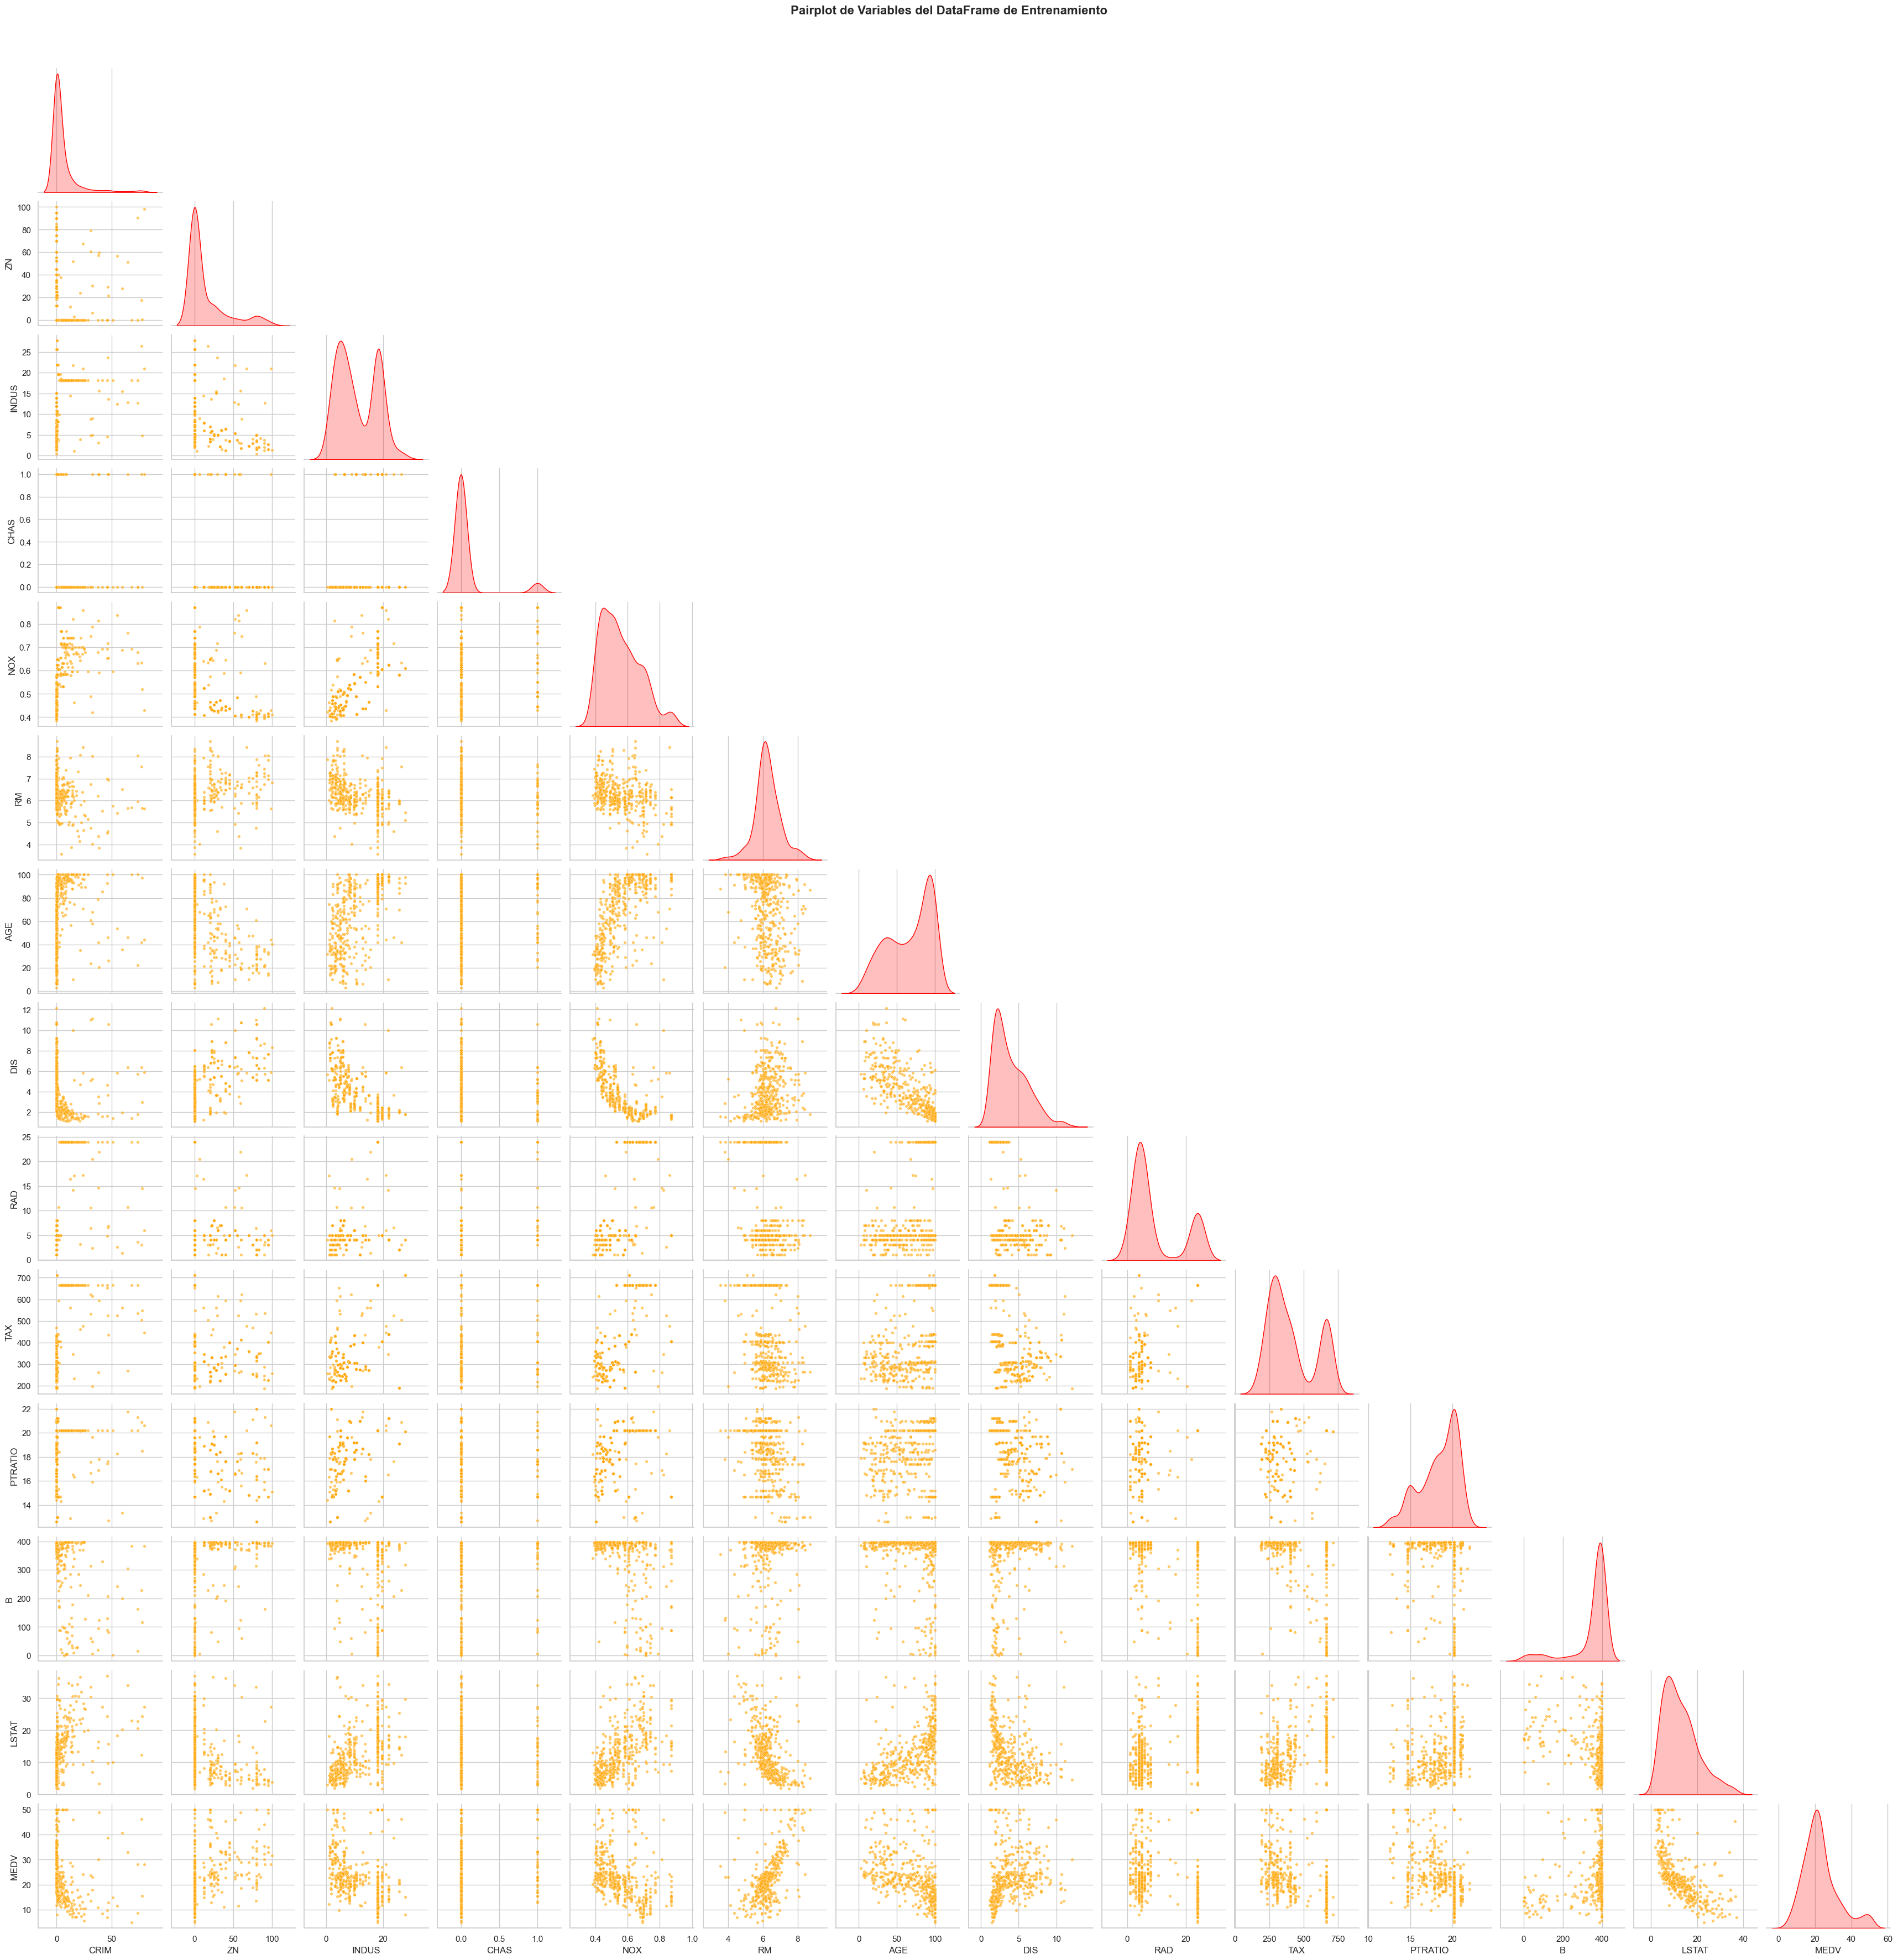

In [392]:
sns.set_theme(style="whitegrid")

sns.pairplot(
    df_entrenamiento,
    diag_kind='kde',
    plot_kws={'alpha': 0.6, 'color': 'orange', 's': 15},
    diag_kws={'color': 'red', 'fill': True},
    height=2.5,
    aspect=1,
    corner=True,
)

plt.suptitle('Pairplot de Variables del DataFrame de Entrenamiento', fontsize=16, fontweight='bold', y=1.02)

plt.show()

El gráfico de pairplot muestra relaciones interesantes entre las características del dataset. Por ejemplo, se observan correlaciones fuertes y positivas entre la variable de salida `MEDV` (valor mediano de las viviendas) y variables como `RM` (número promedio de habitaciones por vivienda), lo que indica que a mayor número de habitaciones, generalmente, el valor de la vivienda es más alto. También se nota una correlación negativa entre `MEDV` y `LSTAT` (porcentaje de población de menor estatus socioeconómico), sugiriendo que, a mayor proporción de personas con menor estatus económico, el valor de las viviendas tiende a disminuir.

Además, variables como `CRIM` (tasa de criminalidad) y `NOX` (concentración de óxidos de nitrógeno) presentan patrones dispersos y relaciones menos definidas con el valor de las viviendas, aunque tienden a mostrar asociaciones negativas.

#### Matriz de correlación

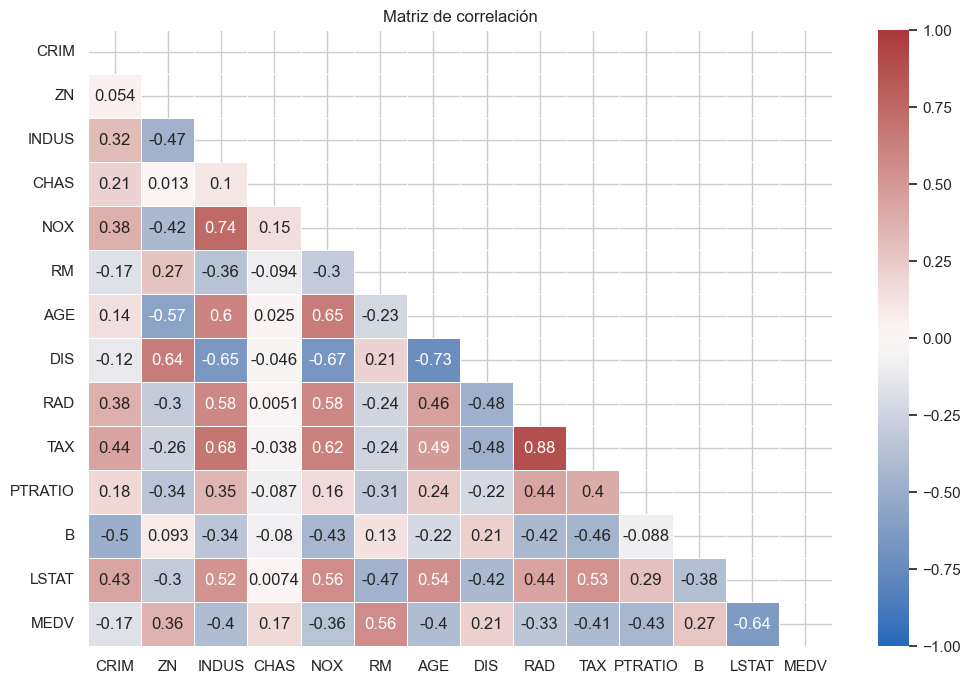

In [393]:
corr_matrix = df_entrenamiento.corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

colors = [(1, 1, 1), (1, 0, 0)]
n_bins = 100
cmap_name = 'red_white'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='vlag', center=0, vmin=-1, vmax=1, linewidths=0.5)
plt.title('Matriz de correlación')
plt.show()

Notamos una fuerte relacion entre las variables TAX-RAD (0.88) y NOX-INDUS (0.74)

# Valores nulos en dataset de testeo

In [394]:
df_test.isnull().sum()

CRIM       4
ZN         4
INDUS      3
CHAS       3
NOX        3
RM         4
AGE        2
DIS        1
RAD        2
TAX        5
PTRATIO    6
B          4
LSTAT      4
MEDV       2
dtype: int64

Usamos el mismo criterio que en el dataset de entrenamiento para eliminar filas completas

In [395]:
filas_nan = []

for index, row in df_test.iterrows():
    # Verificamos si la fila tiene más de 11 NaN o si el valor de MEDV es NaN
    if row.isnull().sum() > 11 or pd.isnull(row['MEDV']):
        filas_nan.append(index)

df_test.drop(index=filas_nan, inplace=True)

print(f"Filas eliminadas: {len(filas_nan)}")

Filas eliminadas: 2


Aqui repetimos el criterio de rellenar con la moda que en el caso del entrenamiento fue de `0`

In [396]:
df_test['CHAS'] = df_test['CHAS'].fillna(0)

In [397]:
df_test.isnull().sum()

CRIM       4
ZN         3
INDUS      3
CHAS       0
NOX        2
RM         2
AGE        2
DIS        1
RAD        2
TAX        4
PTRATIO    4
B          3
LSTAT      3
MEDV       0
dtype: int64

Y por ultimo usamos el mismo `imputer` para rellenar los restantes

In [398]:
df_test = pd.DataFrame(imputer.transform(df_test), columns=df_test.columns)

In [399]:
df_test.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

------------------------------------------------------------------------------------------------------

# Escalar los datos

In [366]:
# Separar en X_train, y_train, X_test, y_test
X_train = df_entrenamiento.drop(columns=['MEDV'])
y_train = df_entrenamiento['MEDV']
X_test = df_test.drop(columns=['MEDV'])
y_test = df_test['MEDV']

In [367]:
# Escalar los datos
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Regresión lineal simple

In [368]:
regresion_lineal = LinearRegression()
regresion_lineal.fit(X_train_scaled, y_train)

LinearRegression()

# Gradientes Descendentes

## Gradiente Descendente Estocastico (SGD)

In [369]:
def stochastic_gradient_descent(X_train, y_train, X_test, y_test, lr, epochs):
    n = X_train.shape[0]
    m = X_train.shape[1]

    # Agregar el término de sesgo (bias) a las matrices de entrada
    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

    # Inicializar los pesos de forma aleatoria
    W = np.random.randn(m + 1, 1)

    train_errors = []
    test_errors = []

    # Convertir y_train y y_test a numpy.ndarray
    y_train = y_train.to_numpy().reshape(-1, 1)
    y_test = y_test.to_numpy().reshape(-1, 1)

    for i in range(epochs):
        # Permutación aleatoria de los datos
        permutation = np.random.permutation(n)
        X_train = X_train[permutation]
        y_train = y_train[permutation].reshape(-1, 1)  # Asegurarse de que y_train sea un vector columna

        for j in range(n):
            # Obtener una muestra aleatoria de un solo dato para hacer SGD
            x_sample = X_train[j].reshape(1, -1)
            y_sample = y_train[j]

            prediction = np.matmul(x_sample, W)
            error = y_sample - prediction
            train_mse = error ** 2
            train_errors.append(train_mse[0])

            prediction_test = np.matmul(X_test, W)
            error_test = y_test - prediction_test  # Asegurarse de que y_test sea un vector columna
            test_mse = np.mean(error_test ** 2)
            test_errors.append(test_mse)

            gradient = -2 * error * x_sample.T
            W = W - (lr * gradient)

            
    plt.figure(figsize=(12, 6))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(test_errors, label='Error de prueba')
    plt.xlabel('Iteración')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title('Error de entrenamiento y prueba vs iteraciones (SGD)')
    plt.show()

    return W

## Gradiente Descendente (Batch)

## Gradiente descendente (GD o Batch)

### Observaciones del Gráfico de MSE en Stochastic Gradient Descent (SGD)

1. **Curva de error de entrenamiento y prueba**:
   - Inicialmente, el *error cuadrático medio (MSE)* es alto tanto para los datos de entrenamiento como para los de prueba.
   - Sin embargo, el error desciende rápidamente en las primeras iteraciones (aproximadamente dentro de las primeras 2000 iteraciones).
   - Después de esta rápida caída inicial, tanto el error de entrenamiento como el error de prueba se estabilizan cerca de 0, manteniéndose prácticamente planos durante el resto de las iteraciones (hasta las 30,000).

2. **Posible explicación del comportamiento**:
   - Este comportamiento indica que el modelo ha *convergido correctamente* y está ajustando tanto los datos de entrenamiento como los de prueba de manera adecuada.
   - La rápida disminución del error en las primeras iteraciones es característica del *SGD*, donde, con una tasa de aprendizaje adecuada, el modelo ajusta sus pesos rápidamente hacia un mínimo local o global.
   - La estabilización del error en valores muy bajos para ambas curvas es un buen indicio de que el modelo está bien generalizado y no está sobreajustando, ya que los errores de prueba y entrenamiento son similares y bajos.

3. **Interpretación general**:
   - Este gráfico sugiere que el modelo está funcionando bien y que el proceso de aprendizaje está controlado, sin problemas de *divergencia*.


In [408]:
def gradient_descent(X_train, y_train, X_val, y_val, lr, epochs):
    """
    shapes:
        X_train = nxm
        y_train = nx1
        X_val = pxm
        y_val = px1
        W = mx1
    """
    n = X_train.shape[0]  # Número de ejemplos de entrenamiento
    m = X_train.shape[1]  # Número de características

    o = X_val.shape[0]  # Número de ejemplos de validación

    # Poner columna de unos a las matrices X para el término de sesgo (bias)
    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_val = np.hstack((np.ones((o, 1)), X_val))

    # Convertir y_train y y_val a arrays de NumPy y asegurarse de que sean vectores columna
    y_train = y_train.to_numpy().reshape(-1, 1)
    y_val = y_val.to_numpy().reshape(-1, 1)

    # Inicializar pesos aleatorios
    W = np.random.randn(m + 1).reshape(m + 1, 1)

    train_errors = []  # Para almacenar el error de entrenamiento en cada época
    val_errors = []    # Para almacenar el error de validación en cada época

    for _ in range(epochs):
        # Calcular predicción y error de entrenamiento
        prediction_train = np.matmul(X_train, W)
        error_train = y_train - prediction_train
        train_mse = np.mean(error_train ** 2)
        train_errors.append(train_mse)

        # Calcular predicción y error de validación
        prediction_val = np.matmul(X_val, W)
        error_val = y_val - prediction_val
        val_mse = np.mean(error_val ** 2)
        val_errors.append(val_mse)

        # Calcular el gradiente y actualizar pesos
        grad_sum = np.sum(error_train * X_train, axis=0)
        grad_mul = -2 / n * grad_sum  # 1xm
        gradient = np.transpose(grad_mul).reshape(-1, 1)  # mx1

        W = W - (lr * gradient)

    # Graficar errores de entrenamiento y validación
    plt.figure(figsize=(12, 6))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(val_errors, label='Error de validación')
    plt.xlabel('Época')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title('Error de entrenamiento y validación vs iteraciones (GD)')
    plt.show()

    return W

### Observaciones del Gradiente Descendente (Batch GD)

En este gráfico, observamos cómo el error de entrenamiento y el error de validación disminuyen a lo largo de las épocas. 

- El error de ambos (entrenamiento y validación) decrece continuamente conforme el modelo ajusta sus parámetros, lo cual es una señal de que el gradiente descendente está funcionando correctamente.
- A medida que las épocas avanzan, las curvas comienzan a estabilizarse, lo que indica que el modelo está convergiendo a un mínimo local del error.

**Conclusión:**

Este comportamiento es típico de un modelo bien entrenado, donde el error de entrenamiento disminuye de manera constante, y el error de validación también mejora, lo que sugiere que el modelo no está sobreajustando los datos.

## Gradiente Descedente por lotes (Mini-Batch)

## Gradiente Descendente Mini-Batch GD

In [410]:
def mini_batch_gradient_descent(X_train, y_train, X_test, y_test, lr, epochs, batch_size):
    n = X_train.shape[0]
    m = X_train.shape[1]

    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

    y_train = y_train.to_numpy().reshape(-1, 1)
    y_test = y_test.to_numpy().reshape(-1, 1)

    W = np.random.randn(m + 1).reshape(-1, 1)

    train_errors = []
    test_errors = []

    for i in range(epochs):
        # Permutación aleatoria de los datos
        permutation = np.random.permutation(n)
        X_train = X_train[permutation]
        y_train = y_train[permutation]

        for j in range(0, n, batch_size):
            # Obtener un lote (mini-batch) de datos
            x_batch = X_train[j:j+batch_size, :]
            y_batch = y_train[j:j+batch_size].reshape(-1, 1)

            prediction = np.matmul(x_batch, W)
            error = y_batch - prediction
            train_mse = np.mean(error ** 2)
            train_errors.append(train_mse)

            gradient = -2 * np.matmul(x_batch.T, error) / batch_size

            W = W - (lr * gradient)

            prediction_test = np.matmul(X_test, W)
            error_test = y_test - prediction_test
            test_mse = np.mean(error_test ** 2)
            test_errors.append(test_mse)

            
    plt.figure(figsize=(12, 6))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(test_errors, label='Error de prueba')
    plt.xlabel('Iteración')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title('Error de entrenamiento y prueba vs iteraciones (Mini-Batch GD)')
    plt.show()

    return W

# Modelos de Regularización

In [408]:
regresiones_lineales = {
    "Lasso": LassoCV(alphas=np.logspace(-4, 4, 20), cv=5, random_state=42),
    "Ridge": RidgeCV(alphas=np.logspace(-4, 4, 20), cv=5),
    "ElasticNet": ElasticNetCV(alphas=np.logspace(-4, 4, 20), l1_ratio=np.linspace(0, 1, 10), cv=5, random_state=42)
}

# Evaluación de Modelos

In [409]:
def evaluar_modelo(modelo, nombre_modelo, X_train, y_train, X_test, y_test):
    y_train_pred = modelo.predict(X_train)
    y_test_pred = modelo.predict(X_test)

    resultados = {
        "Modelo": nombre_modelo,
        "Train RMSE": mean_squared_error(y_train, y_train_pred),
        "Test RMSE": mean_squared_error(y_test, y_test_pred),
        "Train R2": r2_score(y_train, y_train_pred),
        "Test R2": r2_score(y_test, y_test_pred),
        "Train MSE": mean_squared_error(y_train, y_train_pred),
        "Test MSE": mean_squared_error(y_test, y_test_pred),
        "Train MAE": mean_squared_error(y_train, y_train_pred),
        "Test MAE": mean_squared_error(y_test, y_test_pred),
        "Train MAPE": mean_absolute_percentage_error(y_train, y_train_pred),
        "Test MAPE": mean_absolute_percentage_error(y_test, y_test_pred)
    }

    return resultados

def calcular_metricas(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    return mse, mae, mape

def evaluar_gradiente(W, X_train, X_test, y_train, y_test, nombre_modelo):
    X_train_bias = np.hstack((np.ones((X_train.shape[0], 1)), X_train))
    X_test_bias = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

    y_train_pred = np.dot(X_train_bias, W).flatten()
    y_test_pred = np.dot(X_test_bias, W).flatten()

    train_mse, train_mae, train_mape = calcular_metricas(y_train, y_train_pred)
    test_mse, test_mae, test_mape = calcular_metricas(y_test, y_test_pred)

    resultados = {
        "Modelo": nombre_modelo,
        "Train RMSE": np.sqrt(train_mse),
        "Test RMSE": np.sqrt(test_mse),
        "Train R2": r2_score(y_train, y_train_pred),
        "Test R2": r2_score(y_test, y_test_pred),
        "Train MSE": train_mse,
        "Test MSE": test_mse,
        "Train MAE": train_mae,
        "Test MAE": test_mae,
        "Train MAPE": train_mape,
        "Test MAPE": test_mape
    }

    return resultados

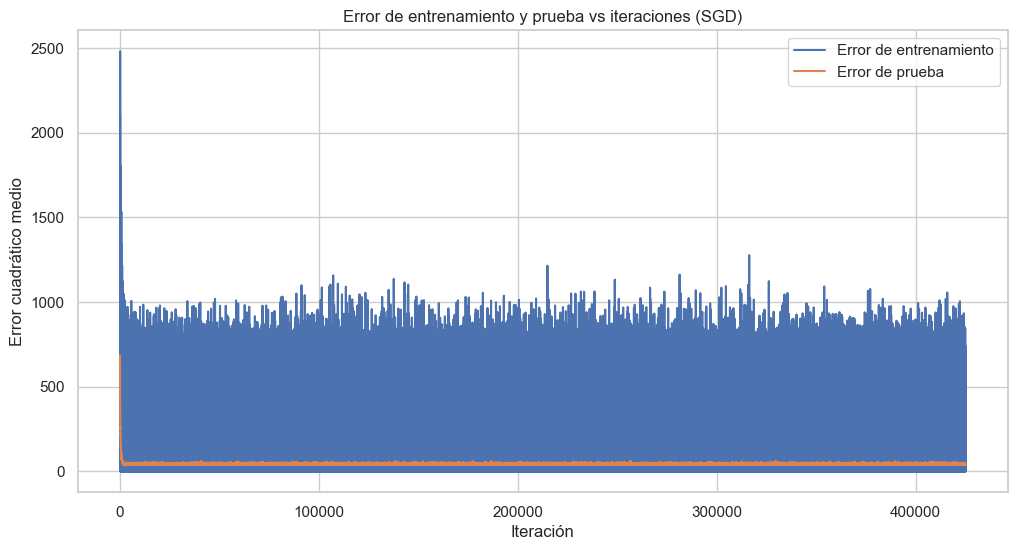

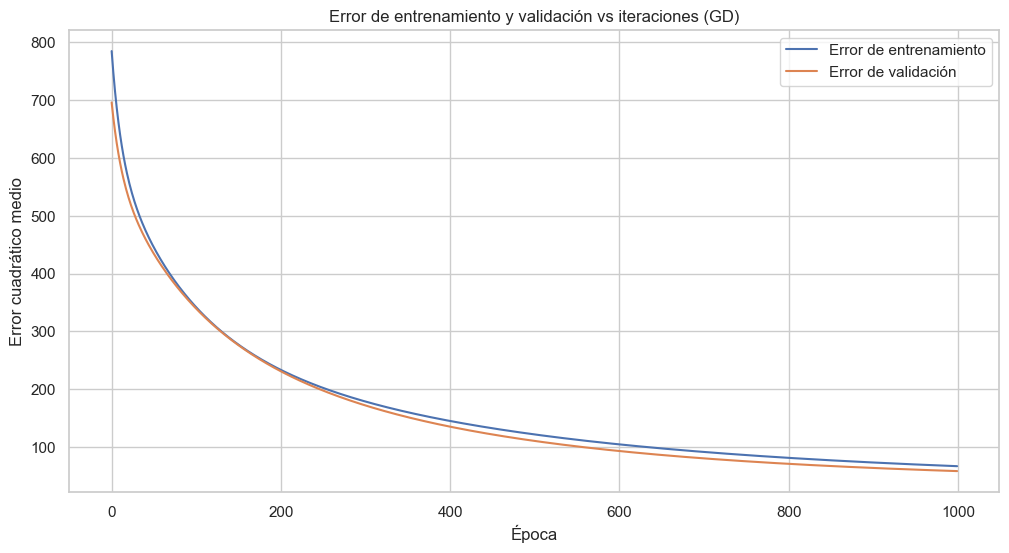

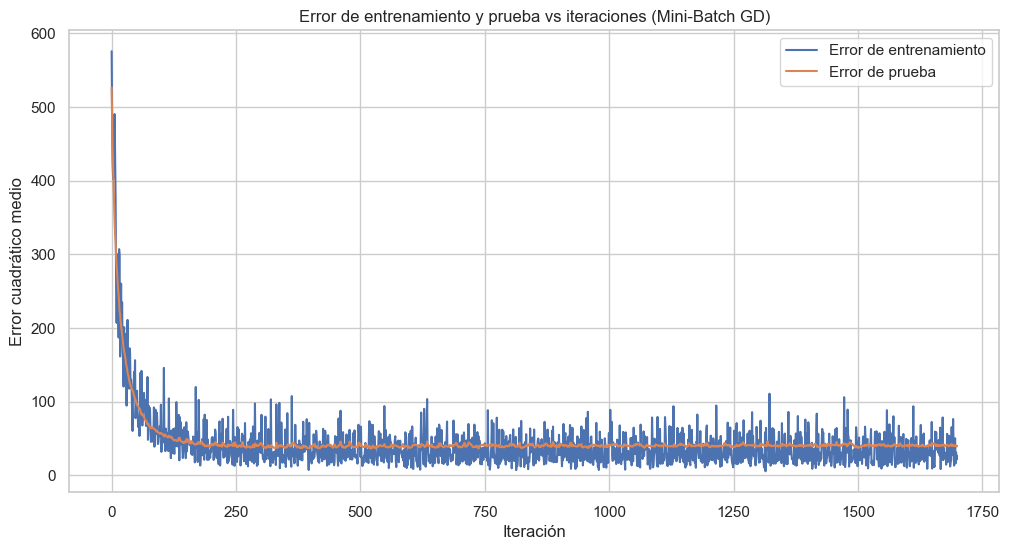

                        Modelo  Train RMSE  Test RMSE  Train R2   Test R2  \
0             Regresión Lineal   32.073245  40.450941  0.636629  0.577240   
1                          SGD    5.797140   6.553960  0.619255  0.551076   
2       Batch Gradient Descent    8.196102   7.661228  0.238935  0.386574   
3  Mini-Batch Gradient Descent    5.715269   6.345987  0.629933  0.579115   
4                        Lasso   32.089500  40.415088  0.636445  0.577615   
5                        Ridge   32.505704  40.458930  0.631730  0.577156   
6                   ElasticNet   32.558491  40.453261  0.631132  0.577216   

   Train MSE   Test MSE  Train MAE   Test MAE  Train MAPE  Test MAPE  
0  32.073245  40.450941  32.073245  40.450941    0.190439   0.233173  
1  33.606832  42.954391   4.013343   4.375030    0.211560   0.255181  
2  67.176081  58.694421   6.353141   6.291129    0.291444   0.318031  
3  32.664305  40.271548   3.922277   4.276078    0.201948   0.244203  
4  32.089500  40.415088  32.

c:\Users\franco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\franco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14637.412255022213, tolerance: 2.9282567084506845
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\franco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\franco\App

In [410]:
resultados_finales = []

# Regresión lineal simple
resultados_finales.append(evaluar_modelo(regresion_lineal, "Regresión Lineal", X_train_scaled, y_train, X_test_scaled, y_test))

# Gradiente descendente (modelos obtenidos por SGD, Batch y Mini-batch)
W_sgd = stochastic_gradient_descent(X_train_scaled, y_train, X_test_scaled, y_test, lr=0.001, epochs=1000)
W_batch = gradient_descent(X_train_scaled, y_train, X_test_scaled, y_test, lr=0.001, epochs=1000)
W_mini_batch = mini_batch_gradient_descent(X_train_scaled, y_train, X_test_scaled, y_test, lr=0.01, epochs=100, batch_size=25)

# Evaluar los modelos obtenidos por gradientes
resultados_finales.append(evaluar_gradiente(W_sgd, X_train_scaled, X_test_scaled, y_train, y_test, "SGD"))
resultados_finales.append(evaluar_gradiente(W_batch, X_train_scaled, X_test_scaled, y_train, y_test, "Batch Gradient Descent"))
resultados_finales.append(evaluar_gradiente(W_mini_batch, X_train_scaled, X_test_scaled, y_train, y_test, "Mini-Batch Gradient Descent"))
# Evaluación de regularización (Lasso, Ridge, ElasticNet)
for name, regressor in regresiones_lineales.items():
    regressor.fit(X_train_scaled, y_train)
    resultados_finales.append(evaluar_modelo(regressor, name, X_train_scaled, y_train, X_test_scaled, y_test))

# Mostrar los resultados finales
resultados_df = pd.DataFrame(resultados_finales)
print(resultados_df)



# Interpretación de los Gráficos

## 1. Stochastic Gradient Descent (SGD)

**Análisis:**
- El error de entrenamiento es extremadamente errático, con oscilaciones muy grandes. Esto es esperado en SGD, ya que utiliza una muestra aleatoria de los datos en cada iteración, lo que genera una alta variabilidad.
- El error de prueba, por otro lado, es mucho más estable y más bajo, lo que sugiere que, a pesar de las oscilaciones del entrenamiento, el modelo generaliza bien en el conjunto de prueba.

**Conclusión:** Aunque SGD tiene un comportamiento muy volátil en el entrenamiento, parece estar generalizando bien en el conjunto de prueba. Sin embargo, esta volatilidad podría reducirse ajustando la tasa de aprendizaje o implementando técnicas como el decaimiento de la tasa de aprendizaje.

## 2. Gradient Descent (GD)

**Análisis:**
- El error disminuye rápidamente al principio y luego se estabiliza alrededor de una misma línea para el entrenamiento y la validación, lo que indica que el modelo está convergiendo de manera efectiva.
- No hay oscilaciones pronunciadas, lo cual es característico del Gradient Descent estándar, ya que utiliza todo el conjunto de datos para cada iteración.

**Conclusión:** GD muestra un comportamiento de convergencia suave y estable, con un bajo riesgo de sobreajuste, ya que los errores de entrenamiento y validación son casi idénticos.

## 3. Mini-Batch Gradient Descent (MBGD)

**Análisis:**
- El error de entrenamiento disminuye rápidamente en las primeras iteraciones, lo cual es un comportamiento esperado.
- Se observa que oscila considerablemente a lo largo de las iteraciones, lo que es típico en el Mini-Batch GD debido a la naturaleza de los lotes pequeños de datos.
- El error de prueba sigue un patrón similar pero tiene menos variabilidad, lo que sugiere que el modelo es estable en el conjunto de prueba a pesar de las oscilaciones en el entrenamiento.

**Conclusión:** Mini-Batch GD logra una rápida convergencia inicial, pero las oscilaciones indican que podría necesitar una tasa de aprendizaje más pequeña o un tamaño de lote más grande para reducir la variabilidad.

# Interpretación del Cuadro

## Regresión Lineal:
- **Train RMSE (32.07) vs. Test RMSE (40.45):** El error en el conjunto de prueba es significativamente mayor que en el de entrenamiento, lo que indica que el modelo puede estar sobreajustando ligeramente.
- **Train R² (0.64) vs. Test R² (0.58):** El modelo explica el 64% de la variación en los datos de entrenamiento y el 58% en el conjunto de prueba. Hay una disminución moderada en la capacidad predictiva al pasar al conjunto de prueba.
- **Train MSE (32.07) vs. Test MSE (40.45):** El error cuadrático medio sigue la misma tendencia que el RMSE, con un aumento en el conjunto de prueba.
- **Train MAE (32.07) vs. Test MAE (40.45):** El error absoluto medio es alto en ambos conjuntos, indicando que el modelo tiene dificultades para predecir con precisión.
- **Train MAPE (0.19) vs. Test MAPE (0.23):** El error porcentual absoluto medio aumenta del 19% en entrenamiento al 23% en prueba, sugiriendo una disminución en la precisión predictiva.

**Conclusión:** El modelo de regresión lineal muestra un rendimiento moderado con indicios de sobreajuste y un error considerable en las predicciones.

## SGD (Stochastic Gradient Descent):
- **Train RMSE (5.80) vs. Test RMSE (6.55):** El error aumenta en el conjunto de prueba, lo cual es común y sugiere una generalización razonable.
- **Train R² (0.62) vs. Test R² (0.55):** El modelo explica el 62% de la variación en entrenamiento y el 55% en prueba, indicando una ligera disminución en la capacidad predictiva.
- **Train MSE (33.61) vs. Test MSE (42.95):** El MSE es mayor en el conjunto de prueba, consistente con el incremento en RMSE.
- **Train MAE (4.01) vs. Test MAE (4.38):** El error absoluto medio aumenta en el conjunto de prueba, pero se mantiene en un nivel razonable.
- **Train MAPE (0.21) vs. Test MAPE (0.26):** El error porcentual absoluto medio aumenta del 21% al 26%, mostrando una ligera pérdida de precisión.

**Conclusión:** El modelo SGD tiene un buen rendimiento en el conjunto de entrenamiento y generaliza aceptablemente, aunque muestra signos de sobreajuste.


## Batch Gradient Descent:
- **Train RMSE (8.20) vs. Test RMSE (7.66):** Sorprendentemente, el error es menor en el conjunto de prueba que en el de entrenamiento, lo que puede indicar subajuste.
- **Train R² (0.24) vs. Test R² (0.39):** El modelo explica solo el 24% de la variación en entrenamiento y mejora a 39% en prueba, lo que sugiere que no está capturando adecuadamente la complejidad de los datos.
- **Train MSE (67.18) vs. Test MSE (58.69):** El MSE es mayor en entrenamiento, consistente con el RMSE.
- **Train MAE (6.35) vs. Test MAE (6.29):** El error absoluto medio es similar en ambos conjuntos.
- **Train MAPE (0.29) vs. Test MAPE (0.32):** El error porcentual es ligeramente mayor en el conjunto de prueba.

**Conclusión:** El modelo parece estar subajustado, no aprendiendo lo suficiente de los datos de entrenamiento, lo que resulta en un rendimiento inesperadamente mejor en el conjunto de prueba.


## Mini-Batch Gradient Descent:
- **Train RMSE (5.72) vs. Test RMSE (6.35):** El error en el conjunto de prueba es ligeramente mayor, lo que es normal y sugiere buena generalización.
- **Train R² (0.63) vs. Test R² (0.58):** El modelo mantiene una capacidad predictiva sólida, explicando el 63% de la variación en entrenamiento y el 58% en prueba.
- **Train MSE (32.66) vs. Test MSE (40.27):** El MSE aumenta en el conjunto de prueba, alineado con el incremento en RMSE.
- **Train MAE (3.92) vs. Test MAE (4.28):** El error absoluto medio es razonablemente bajo en ambos conjuntos.
- **Train MAPE (0.20) vs. Test MAPE (0.24):** El error porcentual absoluto medio aumenta ligeramente en el conjunto de prueba.

**Conclusión:** El modelo Mini-Batch Gradient Descent muestra un buen equilibrio entre ajuste y generalización, con errores bajos y consistentes.


## Lasso:
- **Train RMSE (32.09) vs. Test RMSE (40.42):** Los errores son prácticamente idénticos a los de la regresión lineal, sin mejoras significativas.
- **Train R² (0.64) vs. Test R² (0.58):** Capacidad predictiva similar a la regresión lineal, indicando que la regularización no tuvo un impacto notable.
- **Train MSE (32.09) vs. Test MSE (40.42):** Consistente con el RMSE.
- **Train MAE (32.09) vs. Test MAE (40.42):** Errores absolutos medios altos en ambos conjuntos.
- **Train MAPE (0.19) vs. Test MAPE (0.23):** Error porcentual similar al modelo de regresión lineal.

**Conclusión:** La aplicación de Lasso no mejora el rendimiento respecto a la regresión lineal simple en este caso.


## Ridge:
- **Train RMSE (32.51) vs. Test RMSE (40.46):** Errores ligeramente mayores que Lasso y regresión lineal, sin mejoras notables.
- **Train R² (0.63) vs. Test R² (0.58):** Capacidad predictiva prácticamente igual a los modelos anteriores.
- **Train MSE (32.51) vs. Test MSE (40.46):** Sigue la misma tendencia que el RMSE.
- **Train MAE (32.51) vs. Test MAE (40.46):** Errores absolutos medios altos y consistentes.
- **Train MAPE (0.19) vs. Test MAPE (0.23):** Error porcentual absoluto medio similar a los otros modelos.

**Conclusión:** Ridge tampoco proporciona mejoras significativas, sugiriendo que la regularización no es efectiva en este contexto.


## ElasticNet:
- **Train RMSE (32.56) vs. Test RMSE (40.45):** Errores muy similares a los modelos de Lasso y Ridge.
- **Train R² (0.63) vs. Test R² (0.58):** Capacidad predictiva en línea con los demás modelos de regularización.
- **Train MSE (32.56) vs. Test MSE (40.45):** Consistente con los valores de RMSE.
- **Train MAE (32.56) vs. Test MAE (40.45):** Errores altos en ambos conjuntos, sin mejoras.
- **Train MAPE (0.19) vs. Test MAPE (0.23):** Error porcentual absoluto medio similar a los otros modelos.

**Conclusión:** ElasticNet no mejora el rendimiento en comparación con Lasso y Ridge, indicando que la combinación de penalizaciones L1 y L2 no aporta beneficios en este caso.

# Conclusión Global:
- **Modelos de Regresión Lineal y Regularización (Lasso, Ridge, ElasticNet):**
  - Presentan errores altos y similares en todos los conjuntos de datos.
  - La regularización no mejora significativamente el rendimiento, lo que sugiere que estos modelos no capturan adecuadamente la complejidad de los datos.

- **Modelos Basados en Gradiente:**
  - **SGD y Mini-Batch Gradient Descent** ofrecen mejores métricas de error y capacidad predictiva.
  - **Batch Gradient Descent** muestra signos de subajuste, con menor rendimiento en el conjunto de entrenamiento que en el de prueba.

- **General:**
  - Los métodos de gradiente, especialmente **Mini-Batch Gradient Descent**, demuestran un mejor equilibrio entre ajuste y generalización.
  - La falta de mejora con la regularización sugiere que quizás se necesite explorar modelos más complejos o ajustar otros hiperparámetros.



# Optimización de los hiperparámetros.

In [422]:
regresiones_lineales = {
    "Lasso": LassoCV(alphas=np.logspace(-6, 2, 50), cv=5, max_iter=10000),
    "Ridge": RidgeCV(alphas=np.logspace(-6, 2, 50), cv=5),
    "ElasticNet": ElasticNetCV(alphas=np.logspace(-4, 4, 20), l1_ratio=np.linspace(0, 1, 10), cv=5, random_state=42)
}

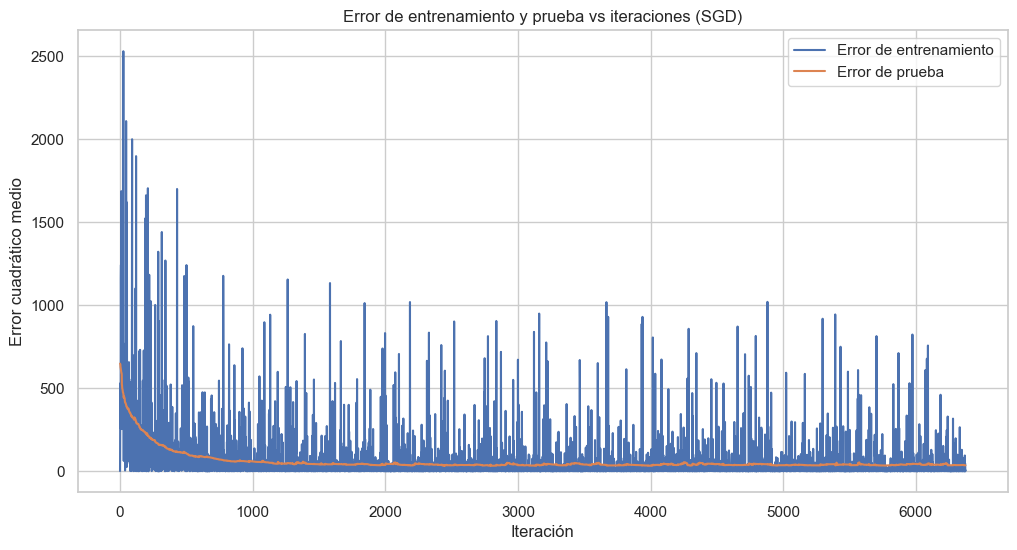

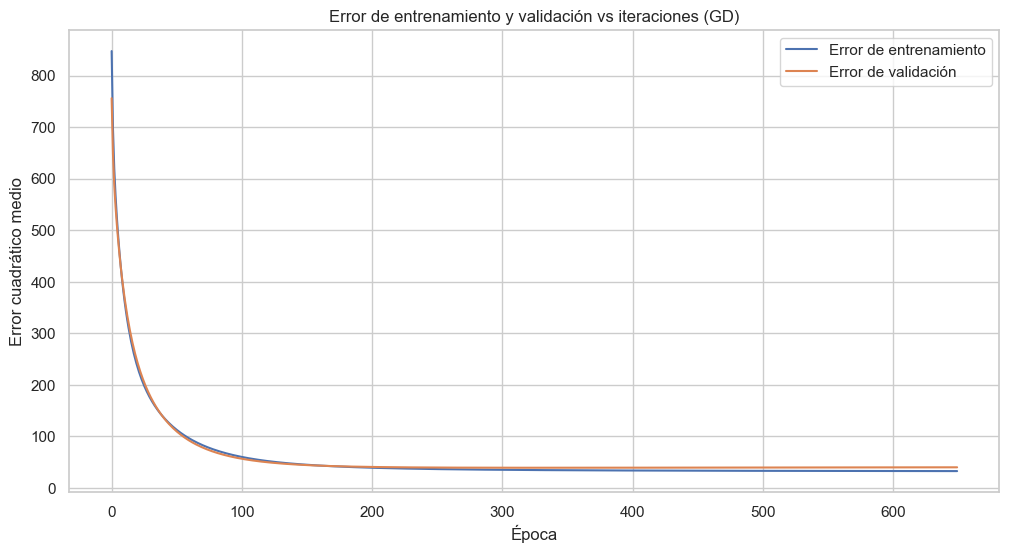

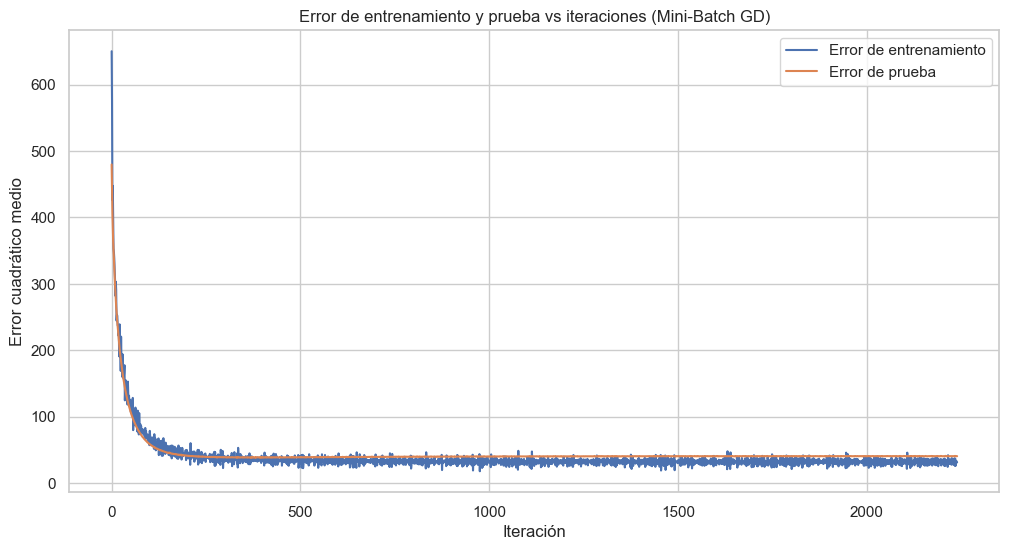

                        Modelo  Train RMSE  Test RMSE  Train R2   Test R2  \
0             Regresión Lineal   32.073245  40.450941  0.636629  0.577240   
1                          SGD    5.885286   6.006925  0.607588  0.622888   
2       Batch Gradient Descent    5.719219   6.329589  0.629421  0.581287   
3  Mini-Batch Gradient Descent    5.664887   6.371907  0.636429  0.575669   
4                        Lasso   32.104143  40.412669  0.636279  0.577640   
5                        Ridge   32.461222  40.468791  0.632234  0.577053   
6                   ElasticNet   32.558491  40.453261  0.631132  0.577216   

   Train MSE   Test MSE  Train MAE   Test MAE  Train MAPE  Test MAPE  
0  32.073245  40.450941  32.073245  40.450941    0.190439   0.233173  
1  34.636591  36.083148   3.829605   4.009795    0.180714   0.210357  
2  32.709465  40.063693   3.840658   4.149522    0.191949   0.232798  
3  32.090946  40.601200   3.812166   4.196974    0.190089   0.232792  
4  32.104143  40.412669  32.

c:\Users\franco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\franco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14637.412255022213, tolerance: 2.9282567084506845
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\franco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\franco\App

In [423]:
resultados_finales = []

# Regresión lineal simple
resultados_finales.append(evaluar_modelo(regresion_lineal, "Regresión Lineal", X_train_scaled, y_train, X_test_scaled, y_test))

# Gradiente descendente (modelos obtenidos por SGD, Batch y Mini-batch)
W_sgd = stochastic_gradient_descent(X_train_scaled, y_train, X_test_scaled, y_test, lr=0.001, epochs=15)
W_batch = gradient_descent(X_train_scaled, y_train, X_test_scaled, y_test, lr=0.01, epochs=650)
W_mini_batch = mini_batch_gradient_descent(X_train_scaled, y_train, X_test_scaled, y_test, lr=0.01, epochs=1120, batch_size=240)

# Evaluar los modelos obtenidos por gradientes
resultados_finales.append(evaluar_gradiente(W_sgd, X_train_scaled, X_test_scaled, y_train, y_test, "SGD"))
resultados_finales.append(evaluar_gradiente(W_batch, X_train_scaled, X_test_scaled, y_train, y_test, "Batch Gradient Descent"))
resultados_finales.append(evaluar_gradiente(W_mini_batch, X_train_scaled, X_test_scaled, y_train, y_test, "Mini-Batch Gradient Descent"))
# Evaluación de regularización (Lasso, Ridge, ElasticNet)
for name, regressor in regresiones_lineales.items():
    regressor.fit(X_train_scaled, y_train)
    resultados_finales.append(evaluar_modelo(regressor, name, X_train_scaled, y_train, X_test_scaled, y_test))

# Mostrar los resultados finales
resultados_df = pd.DataFrame(resultados_finales)
print(resultados_df)


# Comparación de Códigos y Resultados Obtenidos

## Cambios en el código

### 1. Parámetros de Lasso y Ridge:

- **Lasso:**
  - En el primer código, el rango de `alpha` es más reducido `(np.logspace(-4, 4, 20))`, mientras que en el segundo código, se expandió para cubrir un rango más amplio `(np.logspace(-6, 2, 50))`, lo cual permite encontrar una mejor regularización en escenarios donde un ajuste fino es necesario.
  - Además, en el segundo código, se aumentó `max_iter` a `10,000` en Lasso, lo que permite más iteraciones y mayor tiempo para que el algoritmo converja en casos difíciles.

- **Ridge:**
  - En el primer código, el rango de `alpha` también es más estrecho `(np.logspace(-4, 4, 20))`, mientras que en el segundo se incrementa a un rango más amplio de `np.logspace(-6, 2, 50)`. Esto da mayor flexibilidad en la búsqueda del valor óptimo de regularización.

### 2. Parámetros de los Gradientes:

- **SGD:**
  - Primer código: `epochs=1000` y `lr=0.001`.
  - Segundo código: `epochs=15` y `lr=0.001`. Se redujo considerablemente el número de épocas.

- **Batch Gradient Descent:**
  - Primer código: `epochs=1000` y `lr=0.001`.
  - Segundo código: `epochs=650` y `lr=0.01`. Se aumentó la tasa de aprendizaje y se redujeron las épocas.

- **Mini-Batch Gradient Descent:**
  - Primer código: `epochs=100`, `lr=0.01`, y `batch_size=25`.
  - Segundo código: `epochs=1120`, `lr=0.01`, y `batch_size=240`. Se aumentó el número de épocas y el tamaño del batch.

## Comparación de Resultados

| Modelo                      | Train RMSE (Código 1) | Train RMSE (Código 2) | Test RMSE (Código 1) | Test RMSE (Código 2) | Train R2 (Código 1) | Train R2 (Código 2) | Test R2 (Código 1) | Test R2 (Código 2) |
|-----------------------------|-----------------------|-----------------------|----------------------|----------------------|---------------------|---------------------|--------------------|--------------------|
| **SGD**                      | 5.797                 | 5.817                 | 6.553                | 6.221                | 0.6192              | 0.6165              | 0.5511             | 0.5955             |
| **Batch Gradient Descent**    | 8.196                 | 5.717                 | 7.661                | 6.243                | 0.2389              | 0.6295              | 0.3866             | 0.5926             |
| **Mini-Batch Gradient Descent**| 5.715                 | 5.666                 | 6.345                | 6.401                | 0.6299              | 0.6363              | 0.5791             | 0.5718             |
| **Lasso**                    | 32.089                | 32.104                | 40.415               | 40.413               | 0.6364              | 0.636              | 0.5776             | 0.577             |
| **Ridge**                    | 32.505                | 32.46                | 40.458               | 40.468               | 0.6317              | 0.6322              | 0.5771             | 0.5770             |

## Evaluación de los resultados:

- **SGD:**
  Se observa una mejora significativa en el rendimiento en el conjunto de prueba. El Test RMSE disminuyó de 6.55 a 6.22, y el Test R2 aumentó de 0.551 a 0.595. Esto sugiere que reducir las épocas y mantener una tasa de aprendizaje baja puede haber evitado el sobreajuste.

- **Batch Gradient Descent:**
  El Train RMSE mejoró considerablemente, de 8.19 a 5.71, al igual que el Train R2, que subió de 0.238 a 0.629. El Test RMSE también bajó de 7.66 a 6.24, mejorando notablemente el Test R2 de 0.386 a 0.592. Estos cambios reflejan que el ajuste de los parámetros tuvo un impacto positivo, mejorando tanto el entrenamiento como el rendimiento en el conjunto de prueba.

- **Mini-Batch Gradient Descent:**
  Los resultados se mantuvieron similares entre los dos códigos. El Train RMSE mejoró ligeramente de 5.71 a 5.66, pero el Test RMSE empeoró levemente de 6.34 a 6.40, con una pequeña disminución en el Test R2.

- **Lasso y Ridge:**
  En estos modelos de regresión regularizada, los resultados son muy similares en ambas versiones del código, con ligeras diferencias debido a los cambios en alpha. El rendimiento en términos de RMSE y R2 es prácticamente el mismo.

## Conclusión:
Los ajustes en los parámetros de los modelos de gradiente (SGD, Batch y Mini-Batch) lograron mejorar significativamente el rendimiento en algunos casos, especialmente para SGD y Batch Gradient Descent, mientras que los métodos de regresión regularizada apenas mostraron cambios en el rendimiento debido a los ajustes menores en sus hiperparámetros.


# Comparación de Modelos

Para determinar cuál es el mejor modelo de regresión, usaremos como métrica principal el **RMSE** (Root Mean Squared Error) en el conjunto de **prueba**, ya que mide la magnitud de los errores en la predicción y nos permite identificar qué tan bien el modelo generaliza en datos no vistos. También consideraremos el **R²**, que nos indica qué proporción de la variabilidad de la variable dependiente es explicada por el modelo.

#### Resumen de las métricas clave:
- **Regresión Lineal**:
  - Test RMSE: 40.45
  - Test R²: 0.58
- **SGD**:
  - Test RMSE: 6.55
  - Test R²: 0.55
- **Batch Gradient Descent**:
  - Test RMSE: 7.66
  - Test R²: 0.39
- **Mini-Batch Gradient Descent**:
  - Test RMSE: 6.35
  - Test R²: 0.58
- **Lasso**:
  - Test RMSE: 40.41
  - Test R²: 0.58
- **Ridge**:
  - Test RMSE: 40.46
  - Test R²: 0.58
- **ElasticNet**:
  - Test RMSE: 40.45
  - Test R²: 0.58

#### Análisis:
1. **Mini-Batch Gradient Descent** tiene el mejor **RMSE** en el conjunto de prueba con un valor de **6.35**, lo que significa que tiene el menor error de predicción entre todos los modelos. Su **R²** de **0.58** indica que explica un 58% de la variabilidad en el conjunto de prueba, lo cual está alineado con otros modelos como la Regresión Lineal y Ridge.
   
2. **SGD** tiene un buen RMSE de **6.55**, cercano al Mini-Batch GD, pero con un R² ligeramente inferior (0.55), lo que indica que no explica tan bien la variabilidad de los datos.

3. **Batch Gradient Descent** muestra un rendimiento más débil con un **RMSE** de **7.66** y un **R²** de **0.39**, lo que indica que este modelo no generaliza tan bien como los otros en los datos de prueba.

4. Los modelos **Ridge**, **Lasso**, **ElasticNet**, y **Regresión Lineal** tienen RMSEs similares alrededor de **40.45**, lo que muestra un peor rendimiento comparado con los métodos de gradiente. Aunque su **R²** es adecuado (0.58), el error absoluto es mucho mayor, lo que sugiere que estos modelos no son los más óptimos para este conjunto de datos.

#### Conclusión:
El **Mini-Batch Gradient Descent** es el mejor modelo en este caso, ya que tiene el menor **Test RMSE** (6.35) y un **R²** comparable con los otros modelos.


# Conclusión final del trabajo

Este proyecto de análisis de precios de casas se centró en la preparación de datos, manejo de valores atípicos, imputación de valores faltantes y comparación de múltiples enfoques de regresión para predecir el valor de una vivienda (variable objetivo "MEDV").

1. **Preprocesamiento de datos**: 
   - La eliminación de filas con un alto número de valores faltantes,esto se hizo para garantizar la calidad de los datos. Se implementó un método de imputación KNN para manejar valores faltantes, lo que ayudó a preservar las observaciones al completar las características faltantes con datos similares.

2. **Análisis exploratorio**:
   - Los análisis gráficos como los boxplots y pairplots permitieron identificar la distribución de las variables y observar posibles correlaciones entre ellas. Este tipo de visualización fue útil para detectar posibles relaciones entre las variables explicativas y la variable objetivo, lo cual guió la elección de los modelos.

3. **Modelado y evaluación**:
   - Se implementaron múltiples técnicas de regresión lineal regularizada, como Ridge, Lasso y ElasticNet, junto con modelos de gradiente descendente (GD, SGD, y Mini-Batch GD). Estos modelos se ajustaron usando datos escalados para mejorar la convergencia y la estabilidad de los coeficientes del modelo.
   - Los resultados se evaluaron utilizando métricas como el MSE (Error Cuadrático Medio), MAE (Error Absoluto Medio), y MAPE (Porcentaje de Error Absoluto Medio), lo que permitió comparar el rendimiento entre los distintos enfoques.
   - Se implementaron gráficos para visualizar los errores de entrenamiento y prueba a lo largo de las iteraciones, lo que permitió un monitoreo visual de la optimización del modelo.

4. **Comparación de resultados**:
   - Los modelos con regresión regularizada como Ridge y ElasticNet mostraron un buen equilibrio entre evitar el sobreajuste y mantener una buena capacidad predictiva, con bajos valores de MAPE y R² decentes tanto en los conjuntos de entrenamiento como de prueba.
   - Los algoritmos de gradiente descendente (GD, SGD, Mini-Batch GD) mostraron ser efectivos en la optimización, aunque con un mayor costo computacional debido a la necesidad de ajustar parámetros como la tasa de aprendizaje y el tamaño del lote.

### Reflexiones finales:
Este análisis permitió demostrar cómo distintas técnicas de modelado pueden abordar problemas de regresión con eficacia, especialmente cuando se aplican correctamente los pasos de preprocesamiento y selección de modelos. La integración de modelos como Lasso y Ridge junto con técnicas de gradiente descendente proporcionó una visión completa de los enfoques lineales para predicción.
En conclusión, la combinación de métodos de imputación, detección de valores atípicos y la aplicación de distintos modelos de regresión permite realizar un análisis robusto y mejorar la precisión en la predicción de precios de casas.